In [1]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 150)
pd.set_option('display.max_rows', 150)
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
filepaths = []
for year in range(13,19):
    filepath = './data/' + str(year) + 'zpallagi.csv'
    filepaths.append(filepath)

In [3]:
tax_data = {}
for i in range(6):
    tax_data[2013+i] = pd.read_csv(filepaths[i])

In [4]:
for i in range(2013,2019,1):
    print(tax_data[i].shape)

(166740, 114)
(166722, 127)
(166698, 131)
(179796, 147)
(166537, 153)
(165935, 153)


In [5]:
focus_zipcode = pd.read_csv('./data/focus_zipcode.csv')

In [6]:
focus_zipcode['RegionName'] = focus_zipcode['RegionName'].astype('str')
focus_zipcode['RegionName'] = focus_zipcode['RegionName'].apply(lambda x: x.zfill(5))

In [7]:
focus_zipcode.shape

(2872, 2)

In [8]:
def tax_data_clean(df, verbose = True):
    
    #convert all columns to lower cases:
    df.columns = df.columns.str.lower()

    #convert zipcode to str type and fill in leading '0's
    df['zipcode'] = df.zipcode.astype('str')
    df['zipcode'] = df['zipcode'].apply(lambda x: x.zfill(5))
    if verbose:
        print("convert zipcode to str type and fill in leading '0's")
    
    #convert statefips column to categorical variable
    df['statefips'] = df['statefips'].astype('object')
    
    #filter the zipcodes that belong to the top 10 metro area in ZORI data
    df = df.loc[df['zipcode'].isin(focus_zipcode['RegionName']),]
    zips = df['zipcode'].nunique()
    if verbose:
        print(f'Keeping {zips} zipcodes that are included in the top 10 metro area in ZRI data')
    
    #only keep the columns are common to all 6 years' data
    columns_origin = len(df.columns)
    columns = ['statefips','state','zipcode','agi_stub','n1','mars1','mars2','mars4','prep',
           'n2','numdep','a00100','n02650','a02650','n00200','a00200','n00300','a00300','n00600',
           'a00600','n00650','a00650','n00700','a00700','n00900','a00900','n01000','a01000',
           'n01700','a01700','schf','n02300','a02300','n02500','a02500','n26270','a26270',
           'n02900','a02900','n03220','a03220','n03300','a03300','n03270','a03270','n03150',
           'a03150','n03210','a03210','n04470','a04470','a00101','n18425','a18425','n18450',
           'a18450','n18500','a18500','n18300','a18300','n19300','a19300','n19700','a19700',
           'n04800','a04800','n05800','a05800','n09600','a09600','n07100','a07100','n07300',
           'a07300','n07180','a07180','n07230','a07230','n07240','a07240','n07220','a07220',
           'n07260','a07260','n09400','a09400','n10600','a10600','n59660','a59660','n59720',
            'a59720','n11070','a11070','n10960','a10960','n06500','a06500','n10300','a10300',
            'n85300','a85300','n11901','a11901','n11902','a11902']
    try: 
        df = df[columns]
    except:
        df = df[['statefips','state','zipcode','agi_stub','n1','mars1','mars2','mars4','prep',
           'n2','numdep','a00100','n02650','a02650','n00200','a00200','n00300','a00300','n00600',
           'a00600','n00650','a00650','n00700','a00700','n00900','a00900','n01000','a01000',
           'n01750','a01750','schf','n02300','a02300','n02500','a02500','n26270','a26270',
           'n02900','a02900','n03220','a03220','n03300','a03300','n03270','a03270','n03150',
            'a03150','n03210','a03210','n04470','a04470','a00101','n18425','a18425','n18450',
            'a18450','n18500','a18500','n18300','a18300','n19300','a19300','n19700','a19700',
            'n04800','a04800','n05800','a05800','n09600','a09600','n07100','a07100','n07300',
            'a07300','n07180','a07180','n07230','a07230','n07240','a07240','n07225','a07225',
            'n07260','a07260','n09400','a09400','n10600','a10600','n59660','a59660','n59720',
            'a59720','n11070','a11070','n10960','a10960','n06500','a06500','n10300','a10300',
            'n85300','a85300','n11901','a11901','n11902','a11902']]
        df = df.rename(columns={'n01750':'n01700',
                                'a01750':'a01700',
                               'n07225':'n07220',
                               'a07225':'a07220'})
    columns_clean = len(df.columns)
        
    if verbose:
        print(f"Removing {columns_origin - columns_clean} columns that are not common to all 6 years' data")
    
    #remove state level obs (00000) and zipcode were categorized as “other” (99999).
    df = df.loc[(df.zipcode != '00000') & (df.zipcode != '99999'),]
    if verbose:
        print("remove state level obs and zipcodes that were categorized as 'other'.")

    return df

In [9]:
def agi_conversion(df, verbose = True):
    
    #retrive # of high income and low income returns
    df_agi = df[['zipcode','agi_stub','n1']].pivot(index='zipcode',columns='agi_stub',values='n1')
    df_agi['high_income'] = df_agi.iloc[:,4] + df_agi.iloc[:,5]
    df_agi['low_income'] = df_agi.iloc[:,0]
    agi = df_agi.reset_index()[['zipcode','high_income','low_income']]
    
    #combine the high income/ low income info back to main dataframe
    df_byzip = df.groupby('zipcode').sum().reset_index()
    df_byzip = df_byzip.merge(agi, on='zipcode',how='inner')
    df_byzip = df_byzip[df_byzip.columns[df_byzip.columns != 'agi_stub']]
    
    #combine the state info back to the dataset
    df_state = df[['state','zipcode']][~df[['state','zipcode']].duplicated()]
    df_byzip = df_byzip.merge(df_state, on='zipcode',how='left')
    
    if verbose:
        print('retrive and combine the high income/ low income info back to main dataframe')

    return df_byzip
    

In [10]:
def normalization(df, verbose = True):
    
    #create lists of columns need to be normalized by # of return or amount of return
    count_col = []
    amount_col = []
    for col in df.columns:
        if col in ['n1','a00100','a02650']:
            pass
        elif col.startswith('n',0,1):
            count_col.append(col)
        elif col.startswith('a',0,1):
            amount_col.append(col)
    count_col = ['mars1','mars2','mars4','prep','schf','high_income','low_income'] + count_col 

    #normalize the number of retruns columns by dividing total number of returns
    for col in count_col:
        df[col] = df[col]/df['n1']
    if verbose:
        print('normalize the number of retruns columns by dividing total number of returns')

    #normalize the retrun amount columns by dividing total return amount
    for col in amount_col:
        df[col] = df[col]/df['a02650']
    if verbose:
        print('normalize the retrun amount columns by dividing total return amount')

    return df

In [11]:
def standardization(df, verbose = True):
    
    #create a column for average income amount for all returns
    df['avg_income'] = df['a02650']/df['n1']
    
    #convert 'n1','a00100','a02650' into standardized features
    for col in ['n1','a00100','a02650','avg_income']:
        df[col] = (df[col] - df[col].mean())/df[col].std()
    if verbose:
        print("convert 'n1','a00100','a02650','avg_income' into standardized features")
        
    return df

In [22]:
tax_model_data = {}

for i in range(2013,2019,1):
    print(f'year {i}')
    df = tax_data_clean(tax_data[i])
    df = agi_conversion(df)
    df = normalization(df)
    df = standardization(df)
    df['year'] = i
    df['year'] = df['year'].astype('object')
    tax_model_data[i] = df
    print('\n')

year 2013
convert zipcode to str type and fill in leading '0's
Keeping 2861 zipcodes that are included in the top 10 metro area in ZRI data
Removing 8 columns that are not common to all 6 years' data
remove state level obs and zipcodes that were categorized as 'other'.
retrive and combine the high income/ low income info back to main dataframe
normalize the number of retruns columns by dividing total number of returns
normalize the retrun amount columns by dividing total return amount
convert 'n1','a00100','a02650','avg_income' into standardized features


year 2014
convert zipcode to str type and fill in leading '0's
Keeping 2861 zipcodes that are included in the top 10 metro area in ZRI data
Removing 21 columns that are not common to all 6 years' data
remove state level obs and zipcodes that were categorized as 'other'.
retrive and combine the high income/ low income info back to main dataframe
normalize the number of retruns columns by dividing total number of returns
normalize the 

In [24]:
for i in range(2013,2019,1):
    print(tax_model_data[i].shape)

(2861, 108)
(2861, 108)
(2861, 108)
(2869, 108)
(2861, 108)
(2861, 108)


In [13]:
tax_analysis_data = {}

for i in range(2013,2019,1):
    print(f'year {i}')
    df = tax_data_clean(tax_data[i])
    df = agi_conversion(df)
    df = normalization(df)
    df['avg_income'] = df['a02650']/df['n1']
    df['year'] = i
    df['year'] = df['year'].astype('object')
    tax_analysis_data[i] = df
    print('\n')

year 2013
convert zipcode to str type and fill in leading '0's
Keeping 2861 zipcodes that are included in the top 10 metro area in ZRI data
Removing 8 columns that are not common to all 6 years' data
remove state level obs and zipcodes that were categorized as 'other'.
retrive and combine the high income/ low income info back to main dataframe
normalize the number of retruns columns by dividing total number of returns
normalize the retrun amount columns by dividing total return amount


year 2014
convert zipcode to str type and fill in leading '0's
Keeping 2861 zipcodes that are included in the top 10 metro area in ZRI data
Removing 21 columns that are not common to all 6 years' data
remove state level obs and zipcodes that were categorized as 'other'.
retrive and combine the high income/ low income info back to main dataframe
normalize the number of retruns columns by dividing total number of returns
normalize the retrun amount columns by dividing total return amount


year 2015
conve

In [14]:
for i in range(2013,2019,1):
    print(tax_analysis_data[i].shape)

(2861, 108)
(2861, 108)
(2861, 108)
(2869, 108)
(2861, 108)
(2861, 108)


In [15]:
tax_analysis_data[2013].head()

,zipcode,n1,mars1,mars2,mars4,prep,n2,numdep,a00100,n02650,a02650,n00200,a00200,n00300,a00300,n00600,a00600,n00650,a00650,n00700,a00700,n00900,a00900,n01000,a01000,n01700,a01700,schf,n02300,a02300,n02500,a02500,n26270,a26270,n02900,a02900,n03220,a03220,n03300,a03300,n03270,a03270,n03150,a03150,n03210,a03210,n04470,a04470,a00101,n18425,a18425,n18450,a18450,n18500,a18500,n18300,a18300,n19300,a19300,n19700,a19700,n04800,a04800,n05800,a05800,n09600,a09600,n07100,a07100,n07300,a07300,n07180,a07180,n07230,a07230,n07240,a07240,n07220,a07220,n07260,a07260,n09400,a09400,n10600,a10600,n59660,a59660,n59720,a59720,n11070,a11070,n10960,a10960,n06500,a06500,n10300,a10300,n85300,a85300,n11901,a11901,n11902,a11902,high_income,low_income,state,avg_income,year
0,01432,4080.0,0.529412,0.348039,0.107843,0.465686,1.776961,0.497549,246385.0,1.0,249375.0,0.872549,0.813722,0.345588,0.004820,0.193627,0.007046,0.174020,0.004996,0.223039,0.001825,0.125000,0.023992,0.156863,0.008317,0.171569,0.059457,0.0,0.080882,0.009255,0.112745,0.021963,0.029412,0.014047,0.267157,0.011986,0.036765,0.000144,0.000000,0.000000,0.022059,0.002422,0.019608,0.001115,0.112745,0.001957,0.370098,0.120850,0.621935,0.343137,0.029610,0.022059,0.000221,0.343137,0.021951,0.370098,0.053494,0.308824,0.041889,0.279412,0.008313,0.838235,0.690558,0.833333,0.118236,0.022059,0.001059,0.306373,0.005782,0.044118,0.000052,0.056373,0.000489,0.071078,0.001331,0.041667,0.000120,0.147059,0.003152,0.031863,0.000120,0.102941,0.004319,0.965686,0.140976,0.117647,0.003705,0.098039,0.003232,0.066176,0.001223,0.063725,0.000994,0.786765,0.112369,0.818627,0.118035,0.009804,0.000217,0.181373,0.009291,0.791667,0.031419,0.181373,0.311275,MA,61.121324,2013
1,01450,5070.0,0.431953,0.502959,0.055227,0.495069,2.092702,0.729783,653042.0,1.0,667429.0,0.857988,0.674855,0.520710,0.006097,0.390533,0.027116,0.364892,0.019415,0.289941,0.001963,0.185404,0.034634,0.364892,0.059861,0.163708,0.027757,0.0,0.063116,0.004215,0.116371,0.014643,0.078895,0.059845,0.323471,0.016047,0.049310,0.000090,0.023669,0.002580,0.045365,0.003287,0.025641,0.001085,0.094675,0.000796,0.566075,0.133271,0.876210,0.534517,0.049824,0.025641,0.000135,0.540434,0.030655,0.564103,0.082208,0.463511,0.034619,0.479290,0.011062,0.828402,0.745050,0.820513,0.172153,0.130178,0.005004,0.364892,0.003681,0.140039,0.000740,0.057199,0.000229,0.069034,0.000727,0.021696,0.000028,0.122288,0.001170,0.037475,0.000108,0.163708,0.005010,0.940828,0.187307,0.051282,0.000611,0.041420,0.000500,0.029586,0.000262,0.063116,0.000491,0.786982,0.169946,0.818540,0.177451,0.078895,0.002546,0.262327,0.016035,0.672584,0.016838,0.404339,0.274162,MA,131.642801,2013
2,01460,4480.0,0.437500,0.493304,0.053571,0.477679,2.013393,0.636161,431246.0,1.0,437770.0,0.850446,0.787384,0.502232,0.005441,0.359375,0.015983,0.337054,0.010956,0.299107,0.001921,0.176339,0.039242,0.314732,0.031779,0.180804,0.039587,0.0,0.062500,0.005542,0.127232,0.018914,0.062500,0.026630,0.310268,0.014905,0.037946,0.000096,0.015625,0.002721,0.042411,0.003694,0.031250,0.001654,0.100446,0.001074,0.558036,0.150378,0.839445,0.524554,0.042198,0.026786,0.000183,0.537946,0.037600,0.558036,0.081892,0.450893,0.043831,0.475446,0.011812,0.839286,0.733997,0.825893,0.148975,0.093750,0.003856,0.354911,0.004482,0.118304,0.001106,0.071429,0.000368,0.066964,0.000898,0.020089,0.000043,0.127232,0.001642,0.037946,0.000107,0.156250,0.005930,0.941964,0.161331,0.055804,0.000932,0.042411,0.000758,0.029018,0.000361,0.055804,0.000567,0.799107,0.144494,0.828125,0.152530,0.051339,0.000811,0.252232,0.015147,0.685268,0.020981,0.366071,0.276786,MA,97.716518,2013
3,01463,5820.0,0.475945,0.441581,0.073883,0.465636,1.914089,0.580756,422258.0,1.0,428134.0,0.865979,0.777997,0.408935,0.003954,0.237113,0.010389,0.218213,0.007026,0.266323,0.002137,0.149485,0.031049,0.195876,0.027347,0.182131,0.053096,0.0,0.082474,0.009252,0.113402,0.019492,0.042955,0.033452,0.286942,0.013722,0.036082,0.000119,0.006873,0.000906,0.032646,0.003424,0.022337,0.001308,0.109966,0.00

## For data analysis, we select a few features to focus on.

There are many taxable income subcategories, to limit the resources on important feature, we will only look at the subcategories appear in more than 20% of all tax return files. In the meantime, we will also include columns that could be a defining feature of local population, such as porportion of high income house hold. We will exclude columns don't provide much unique information. 

In [17]:
sample = tax_analysis_data[2013]

In [18]:
sample.mean()[sample.mean() > 0.2]

zipcode                 inf
n1             1.254171e+04
mars1          4.765556e-01
mars2          3.604277e-01
prep           5.905149e-01
n2             1.964646e+00
numdep         6.746076e-01
a00100         9.278071e+05
n02650         1.000001e+00
a02650         9.411321e+05
n00200         8.361612e-01
a00200         7.338802e-01
n00300         3.366395e-01
n00600         2.241097e-01
n00650         2.079106e-01
n02900         2.715033e-01
n04470         3.912210e-01
a00101         6.487199e-01
n18425         3.054938e-01
n18500         3.301930e-01
n18300         3.889569e-01
n19300         2.828955e-01
n19700         3.306215e-01
n04800         7.780545e-01
a04800         6.588142e-01
n05800         7.710731e-01
n07100         3.142880e-01
n10600         9.470977e-01
n06500         6.996742e-01
n10300         7.645677e-01
n11902         7.491953e-01
high_income    2.088428e-01
low_income     3.585000e-01
avg_income     8.369851e+01
year           2.013000e+03
dtype: float64

In [17]:
important_features = ['zipcode','n1','mars1','mars2','numdep',\
                     'a02650','n00200','n00300','n01700',\
                     'a04800','high_income','low_income','state','avg_income','year']

In [18]:
full_analysis = tax_analysis_data[2013][important_features]
for i in range(2014,2019,1):
    full_analysis = pd.concat([full_analysis,tax_analysis_data[i][important_features]])

In [19]:
full_analysis.columns = ['zipcode','num_return','num_single','num_joint','num_dependent',\
                     'income_amt','num_salary','num_w_interests','num_pensions',\
                     'taxable_income_amt','high_income','low_income','state','avg_income','year']

In [20]:
features = ['num_return', 'num_single', 'num_joint', 'num_dependent',
       'income_amt', 'num_salary', 'num_w_interests', 'num_pensions',
       'taxable_income_amt', 'high_income', 'low_income','avg_income']

AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)
AxesSubplot(0.125,0.125;0.775x0.755)


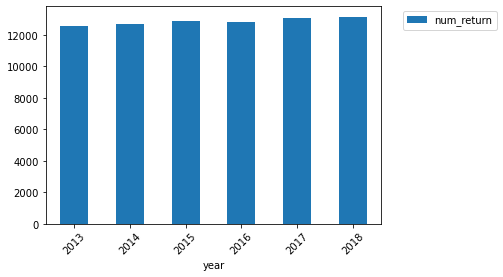

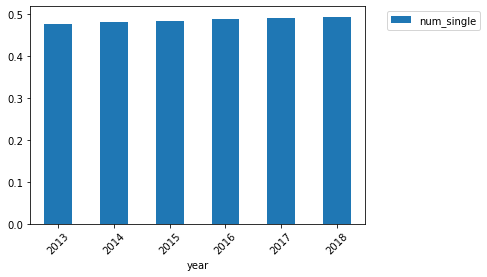

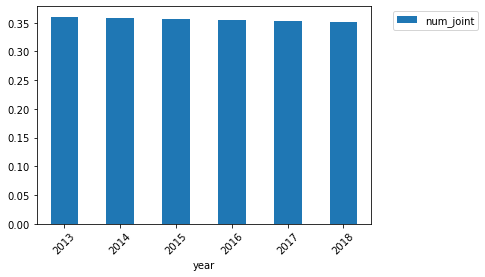

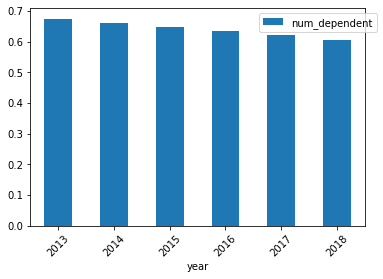

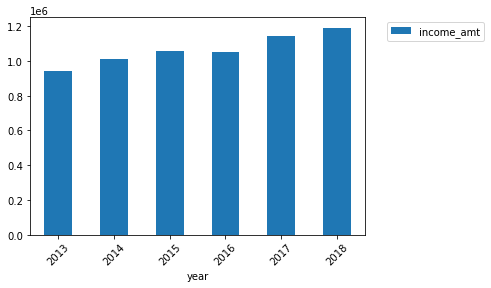

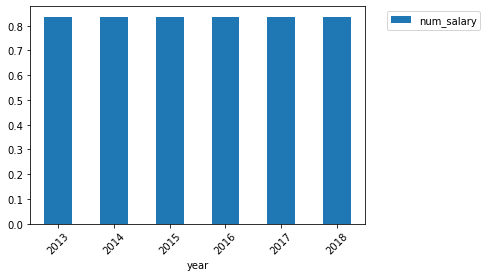

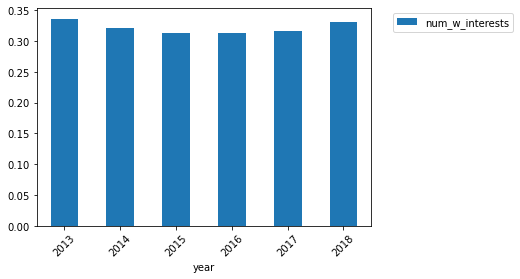

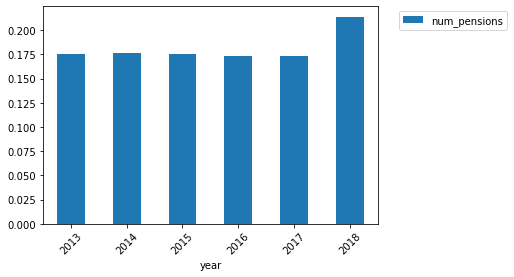

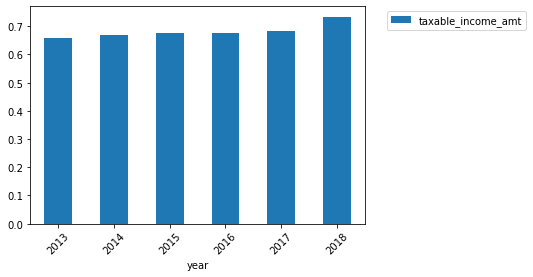

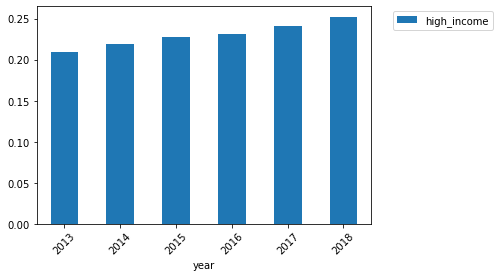

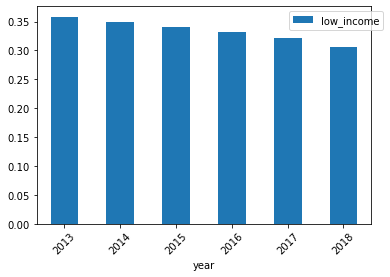

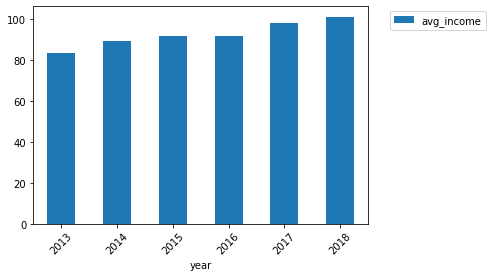

In [23]:
for col in features:
    print(full_analysis.groupby('year')[[col]].mean().reset_index().plot.bar(x='year', y=col, rot=45))
    plt.legend(bbox_to_anchor=(1.05, 1))

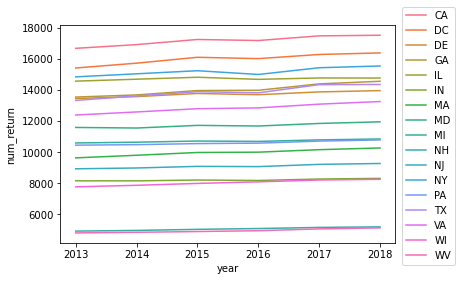

In [24]:
table = full_analysis.groupby(['year','state']).mean()['num_return'].reset_index()
sns.lineplot(data=table, x="year", y="num_return", hue="state")
plt.legend(bbox_to_anchor=(1.1, -0.1), loc=8, borderaxespad=0.)

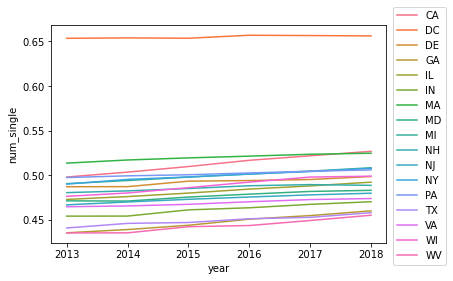

In [25]:
table = full_analysis.groupby(['year','state']).mean()['num_single'].reset_index()
sns.lineplot(data=table, x="year", y="num_single", hue="state")
plt.legend(bbox_to_anchor=(1.1, -0.1), loc=8, borderaxespad=0.)

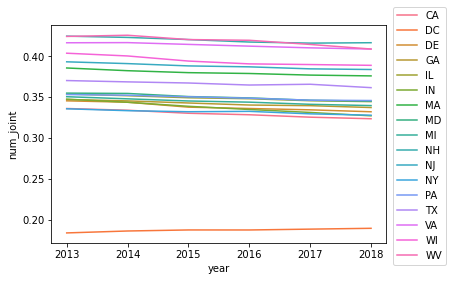

In [26]:
table = full_analysis.groupby(['year','state']).mean()['num_joint'].reset_index()
sns.lineplot(data=table, x="year", y='num_joint', hue="state")
plt.legend(bbox_to_anchor=(1.1, -0.1), loc=8, borderaxespad=0.)

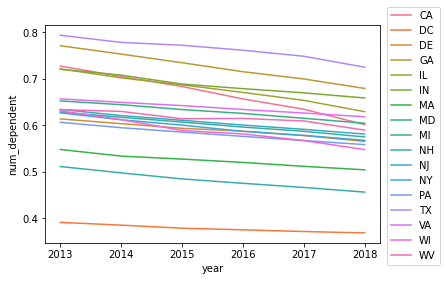

In [27]:
table = full_analysis.groupby(['year','state']).mean()['num_dependent'].reset_index()
sns.lineplot(data=table, x="year", y='num_dependent', hue="state")
plt.legend(bbox_to_anchor=(1.1, -0.1), loc=8, borderaxespad=0.)

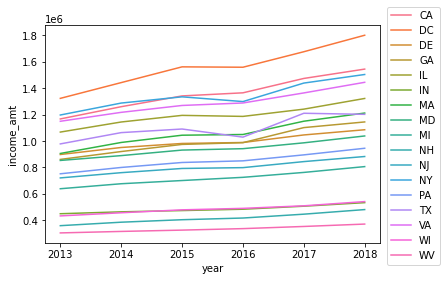

In [28]:
table = full_analysis.groupby(['year','state']).mean()['income_amt'].reset_index()
sns.lineplot(data=table, x="year", y='income_amt', hue="state")
plt.legend(bbox_to_anchor=(1.1, -0.1), loc=8, borderaxespad=0.)

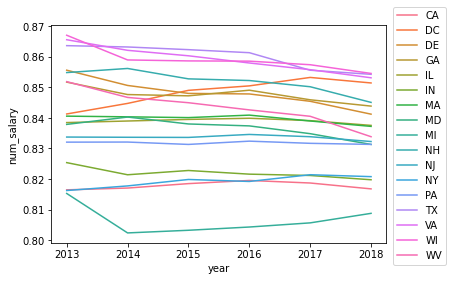

In [29]:
table = full_analysis.groupby(['year','state']).mean()['num_salary'].reset_index()
sns.lineplot(data=table, x="year", y='num_salary', hue="state")
plt.legend(bbox_to_anchor=(1.1, -0.1), loc=8, borderaxespad=0.)

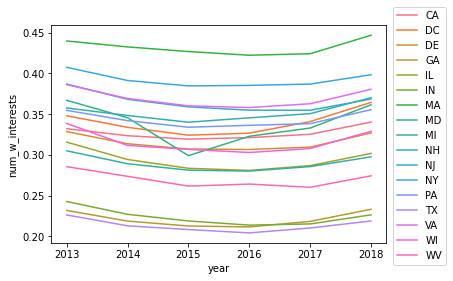

In [30]:
table = full_analysis.groupby(['year','state']).mean()['num_w_interests'].reset_index()
sns.lineplot(data=table, x="year", y='num_w_interests', hue="state")
plt.legend(bbox_to_anchor=(1.1, -0.1), loc=8, borderaxespad=0.)

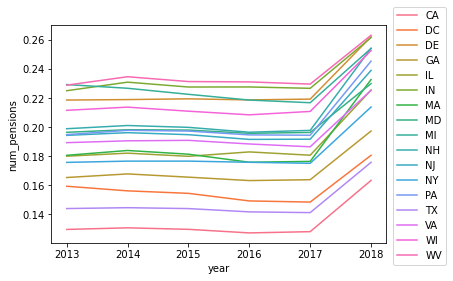

In [31]:
table = full_analysis.groupby(['year','state']).mean()['num_pensions'].reset_index()
sns.lineplot(data=table, x="year", y='num_pensions', hue="state")
plt.legend(bbox_to_anchor=(1.1, -0.1), loc=8, borderaxespad=0.)

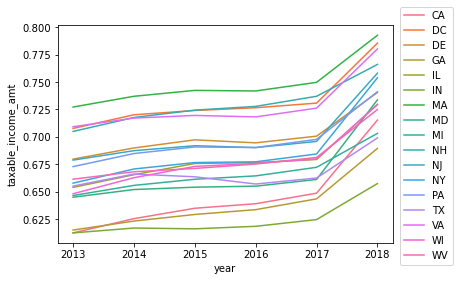

In [32]:
table = full_analysis.groupby(['year','state']).mean()['taxable_income_amt'].reset_index()
sns.lineplot(data=table, x="year", y='taxable_income_amt', hue="state")
plt.legend(bbox_to_anchor=(1.1, -0.1), loc=8, borderaxespad=0.)

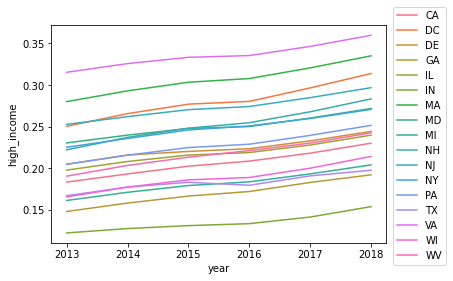

In [33]:
table = full_analysis.groupby(['year','state']).mean()['high_income'].reset_index()
sns.lineplot(data=table, x="year", y='high_income', hue="state")
plt.legend(bbox_to_anchor=(1.1, -0.1), loc=8, borderaxespad=0.)

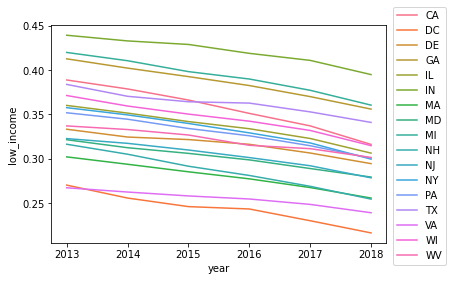

In [34]:
table = full_analysis.groupby(['year','state']).mean()['low_income'].reset_index()
sns.lineplot(data=table, x="year", y='low_income', hue="state")
plt.legend(bbox_to_anchor=(1.1, -0.1), loc=8, borderaxespad=0.)

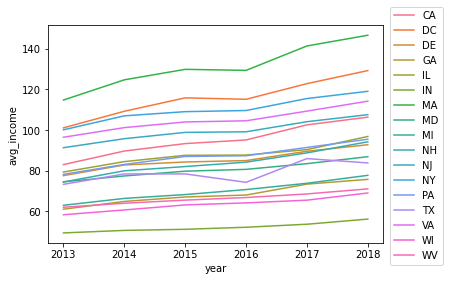

In [35]:
table = full_analysis.groupby(['year','state']).mean()['avg_income'].reset_index()
sns.lineplot(data=table, x="year", y='avg_income', hue="state")
plt.legend(bbox_to_anchor=(1.1, -0.1), loc=8, borderaxespad=0.)

It seems during 2016 tax reformation, the tax return filed in Alaska showed abnormal pattern in many aspects.

In [36]:
for i in range(2013,2019,1):
    print(f'year {i}')
    print('\n')
    df = full_analysis.loc[full_analysis['year']==i,]
    for col in features:
        print(col)
        print(df[col].mean())
        print('\n')
        print(df.set_index('zipcode')[col].sort_values(ascending = False).head(3))
        print(df.set_index('zipcode')[col].sort_values(ascending = True).head(3))
        print('\n')
        print('\n')

year 2013


num_return
12541.709192590004


zipcode
11220    51970.0
11226    50400.0
11373    49090.0
Name: num_return, dtype: float64
zipcode
07723    460.0
18435    490.0
12853    640.0
Name: num_return, dtype: float64




num_single
0.4765555532334064


zipcode
02113    0.864368
20036    0.843243
02215    0.827883
Name: num_single, dtype: float64
zipcode
77441    0.267490
10952    0.293735
77494    0.295219
Name: num_single, dtype: float64




num_joint
0.3604276807638204


zipcode
77441    0.662551
77494    0.621471
10952    0.620016
Name: num_joint, dtype: float64
zipcode
60621    0.042893
60624    0.048257
19121    0.052632
Name: num_joint, dtype: float64




num_dependent
0.6746076204045794


zipcode
10952    1.864117
08701    1.731481
48209    1.710805
Name: num_dependent, dtype: float64
zipcode
92637    0.050777
02113    0.071264
20037    0.081420
Name: num_dependent, dtype: float64




income_amt
941132.1265291856


zipcode
10128    10972659.0
10023    10861855.0
10022    10

Name: num_salary, dtype: float64




num_w_interests
0.3129374363363088


zipcode
90067    0.690476
11576    0.688103
11962    0.685714
Name: num_w_interests, dtype: float64
zipcode
75210    0.017182
76105    0.030534
75237    0.031291
Name: num_w_interests, dtype: float64




num_pensions
0.17341527353083908


zipcode
92637    0.549039
08759    0.537640
08757    0.442165
Name: num_pensions, dtype: float64
zipcode
90006    0.029987
90011    0.031551
90057    0.032819
Name: num_pensions, dtype: float64




taxable_income_amt
0.674326245920715


zipcode
75230    0.991409
77005    0.874877
75205    0.868912
Name: taxable_income_amt, dtype: float64
zipcode
75210    0.312292
48210    0.337864
76105    0.351776
Name: taxable_income_amt, dtype: float64




high_income
0.23084989834471042


zipcode
10069    0.633218
77441    0.612903
10514    0.602612
Name: high_income, dtype: float64
zipcode
75210    0.000000
19133    0.004785
08105    0.006903
Name: high_income, dtype: float64




low_income

From EDA, we know that a good proportion of the data has some fluctuation in year 2016 due to the tax reformation of that year. Year 2017 is a turning point for some states as well. 

The income amount, average income, and proportion of high income returns as well as a number of other features show a growing trajectory over year. 

In [25]:
full_irs = tax_model_data[2013]
for i in range(2014,2019,1):
    full_irs = pd.concat([full_irs,tax_model_data[i]])

In [26]:
full_irs.shape

(17174, 108)

In [27]:
full_irs['index'] = full_irs['year'].astype(str) +'-' + full_irs['zipcode']

In [28]:
full_irs.head()

,zipcode,n1,mars1,mars2,mars4,prep,n2,numdep,a00100,n02650,a02650,n00200,a00200,n00300,a00300,n00600,a00600,n00650,a00650,n00700,a00700,n00900,a00900,n01000,a01000,n01700,a01700,schf,n02300,a02300,n02500,a02500,n26270,a26270,n02900,a02900,n03220,a03220,n03300,a03300,n03270,a03270,n03150,a03150,n03210,a03210,n04470,a04470,a00101,n18425,a18425,n18450,a18450,n18500,a18500,n18300,a18300,n19300,a19300,n19700,a19700,n04800,a04800,n05800,a05800,n09600,a09600,n07100,a07100,n07300,a07300,n07180,a07180,n07230,a07230,n07240,a07240,n07220,a07220,n07260,a07260,n09400,a09400,n10600,a10600,n59660,a59660,n59720,a59720,n11070,a11070,n10960,a10960,n06500,a06500,n10300,a10300,n85300,a85300,n11901,a11901,n11902,a11902,high_income,low_income,state,avg_income,year,index
0,01432,-0.976213,0.529412,0.348039,0.107843,0.465686,1.776961,0.497549,-0.770415,1.0,-0.769467,0.872549,0.813722,0.345588,0.004820,0.193627,0.007046,0.174020,0.004996,0.223039,0.001825,0.125000,0.023992,0.156863,0.008317,0.171569,0.059457,0.0,0.080882,0.009255,0.112745,0.021963,0.029412,0.014047,0.267157,0.011986,0.036765,0.000144,0.000000,0.000000,0.022059,0.002422,0.019608,0.001115,0.112745,0.001957,0.370098,0.120850,0.621935,0.343137,0.029610,0.022059,0.000221,0.343137,0.021951,0.370098,0.053494,0.308824,0.041889,0.279412,0.008313,0.838235,0.690558,0.833333,0.118236,0.022059,0.001059,0.306373,0.005782,0.044118,0.000052,0.056373,0.000489,0.071078,0.001331,0.041667,0.000120,0.147059,0.003152,0.031863,0.000120,0.102941,0.004319,0.965686,0.140976,0.117647,0.003705,0.098039,0.003232,0.066176,0.001223,0.063725,0.000994,0.786765,0.112369,0.818627,0.118035,0.009804,0.000217,0.181373,0.009291,0.791667,0.031419,0.181373,0.311275,MA,-0.329901,2013,2013-01432
1,01450,-0.861998,0.431953,0.502959,0.055227,0.495069,2.092702,0.729783,-0.310649,1.0,-0.304450,0.857988,0.674855,0.520710,0.006097,0.390533,0.027116,0.364892,0.019415,0.289941,0.001963,0.185404,0.034634,0.364892,0.059861,0.163708,0.027757,0.0,0.063116,0.004215,0.116371,0.014643,0.078895,0.059845,0.323471,0.016047,0.049310,0.000090,0.023669,0.002580,0.045365,0.003287,0.025641,0.001085,0.094675,0.000796,0.566075,0.133271,0.876210,0.534517,0.049824,0.025641,0.000135,0.540434,0.030655,0.564103,0.082208,0.463511,0.034619,0.479290,0.011062,0.828402,0.745050,0.820513,0.172153,0.130178,0.005004,0.364892,0.003681,0.140039,0.000740,0.057199,0.000229,0.069034,0.000727,0.021696,0.000028,0.122288,0.001170,0.037475,0.000108,0.163708,0.005010,0.940828,0.187307,0.051282,0.000611,0.041420,0.000500,0.029586,0.000262,0.063116,0.000491,0.786982,0.169946,0.818540,0.177451,0.078895,0.002546,0.262327,0.016035,0.672584,0.016838,0.404339,0.274162,MA,0.700569,2013,2013-01450
2,01460,-0.930065,0.437500,0.493304,0.053571,0.477679,2.013393,0.636161,-0.561411,1.0,-0.559909,0.850446,0.787384,0.502232,0.005441,0.359375,0.015983,0.337054,0.010956,0.299107,0.001921,0.176339,0.039242,0.314732,0.031779,0.180804,0.039587,0.0,0.062500,0.005542,0.127232,0.018914,0.062500,0.026630,0.310268,0.014905,0.037946,0.000096,0.015625,0.002721,0.042411,0.003694,0.031250,0.001654,0.100446,0.001074,0.558036,0.150378,0.839445,0.524554,0.042198,0.026786,0.000183,0.537946,0.037600,0.558036,0.081892,0.450893,0.043831,0.475446,0.011812,0.839286,0.733997,0.825893,0.148975,0.093750,0.003856,0.354911,0.004482,0.118304,0.001106,0.071429,0.000368,0.066964,0.000898,0.020089,0.000043,0.127232,0.001642,0.037946,0.000107,0.156250,0.005930,0.941964,0.161331,0.055804,0.000932,0.042411,0.000758,0.029018,0.000361,0.055804,0.000567,0.799107,0.144494,0.828125,0.152530,0.051339,0.000811,0.252232,0.015147,0.685268,0.020981,0.366071,0.276786,MA,0.204833,2013,2013-01460
3,01463,-0.775472,0.475945,0.441581,0.073883,0.465636,1.914089,0.580756,-0.571573,1.0,-0.570627,0.865979,0.777997,0.408935,0.003954,0.237113,0.010389,0.218213,0.007026,0.266323,0.002137,0.149485,0.031049,0.195876,0.027347,0.182131,0.053096,0.0,0.082474,0.009252,0.113402,0.019492,0.042955,0.033452,0.286942,0.013722,0.036082,0.000119,0.006873,0.

In [41]:
# full_irs.to_csv('full_irs.csv', index=False)